In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet


In [ ]:
# Step 1: Import libraries
import pandas as pd

# Step 2: Load the Superstore dataset
try:
    df = pd.read_csv('/content/sample_data/superstore.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('/content/sample_data/superstore.csv', encoding='latin-1')


# Step 3: Show the first 5 rows
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Group by month and sum sales
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='MS'))['Sales'].sum().reset_index()

# Rename columns for Prophet
monthly_sales = monthly_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

monthly_sales.head()


,ds,y
0,2014-01-01,14236.895
1,2014-02-01,4519.892
2,2014-03-01,55691.009
3,2014-04-01,28295.345
4,2014-05-01,23648.287


In [ ]:
# Initialize model
model = Prophet()

# Fit model to sales data
model.fit(monthly_sales)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0wni7vz/vjxp0bof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0wni7vz/_jk7sfsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81239', 'data', 'file=/tmp/tmpj0wni7vz/vjxp0bof.json', 'init=/tmp/tmpj0wni7vz/_jk7sfsu.json', 'output', 'file=/tmp/tmpj0wni7vz/prophet_modelmspj4auv/prophet_model-20250727133041.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:30:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:30:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create future dataframe (12 months ahead)
future = model.make_future_dataframe(periods=12, freq='MS')

# Predict future sales
forecast = model.predict(future)


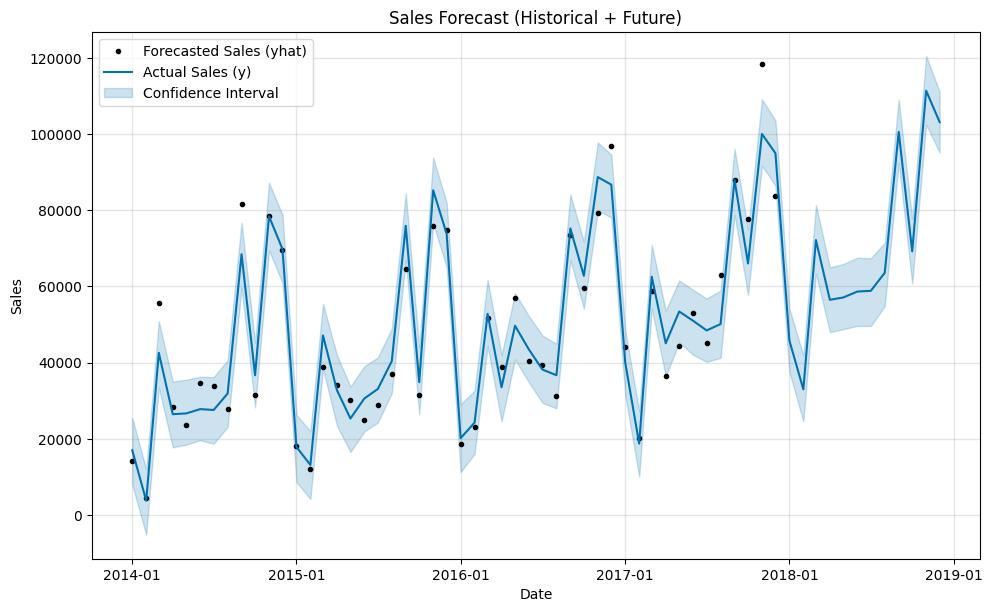

In [ ]:
from matplotlib.dates import DateFormatter

# Plot with custom legend
fig = model.plot(forecast)
ax = fig.gca()

# Set title and labels
ax.set_title("Sales Forecast (Historical + Future)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

# Format x-axis dates
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Add custom legend
ax.legend(['Forecasted Sales (yhat)', 'Actual Sales (y)', 'Confidence Interval'],
          loc='upper left', frameon=True)

plt.show()


In [ ]:
# Merge historical actual sales with predictions
forecast_df = forecast[['ds', 'yhat']].copy()
actual_df = monthly_sales.copy()

actual_df['origin'] = 'Actual'
forecast_df['origin'] = 'Forecast'
forecast_df = forecast_df.rename(columns={'yhat': 'y'})

# Combine actual and forecast
combined = pd.concat([actual_df, forecast_df], ignore_index=True)
combined = combined.sort_values(by='ds').reset_index(drop=True)

# Pivot for Power BI (optional structure)
combined['Actual Sales'] = combined.apply(lambda row: row['y'] if row['origin'] == 'Actual' else None, axis=1)
combined['Predicted Sales'] = combined.apply(lambda row: row['y'] if row['origin'] == 'Forecast' else None, axis=1)
combined = combined[['ds', 'Actual Sales', 'Predicted Sales']]

# Export to CSV
combined.to_csv("sales_forecast_combined.csv", index=False)
print("✅ File 'sales_forecast_combined.csv' created successfully!")


✅ File 'sales_forecast_combined.csv' created successfully!


In [ ]:
# Step 1: Import required libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 2: Load the Superstore data
try:
    df = pd.read_csv('/content/sample_data/superstore.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('/content/sample_data/superstore.csv', encoding='latin-1')

# Step 3: Preprocess the data
df['Order Date'] = pd.to_datetime(df['Order Date'])
df_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
df_sales = df_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Step 4: Train the Prophet model
model = Prophet()
model.fit(df_sales)

# Step 5: Create future dataframe (365 days into the future)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Step 6: Separate actual and future predictions
last_actual_date = df_sales['ds'].max()

# Historical Data
actual_sales = df_sales.copy()
actual_sales = actual_sales.rename(columns={'ds': 'Date', 'y': 'Actual Sales'})

# Future Forecasts Only (dates beyond historical data)
future_forecast = forecast[forecast['ds'] > last_actual_date][['ds', 'yhat']]
future_forecast = future_forecast.rename(columns={'ds': 'Date', 'yhat': 'Predicted Sales'})

# Step 7: Save to CSV
# Export both to separate sheets (optional) or combine into one CSV

# Method 1: Combined CSV (with empty columns for cleaner Power BI import)
combined_df = pd.merge(actual_sales, future_forecast, on='Date', how='outer')
combined_df.to_csv('clean_sales_forecast.csv', index=False)
print("✅ 'clean_sales_forecast.csv' generated successfully.")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0wni7vz/sz2yx7p5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0wni7vz/2mcr2ct3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33135', 'data', 'file=/tmp/tmpj0wni7vz/sz2yx7p5.json', 'init=/tmp/tmpj0wni7vz/2mcr2ct3.json', 'output', 'file=/tmp/tmpj0wni7vz/prophet_modelmy317itq/prophet_model-20250727133608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:36:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:36:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ 'clean_sales_forecast.csv' generated successfully.
